# Transfer Capsnet OCT classifier - Arjun Balaji

In [1]:
import numpy as np
import torch, os, sys, time, argparse, json
import model as m
import dataset as d
from model import *
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from fastai.vision import *
from skimage.filters import gaussian
from sklearn import preprocessing
import skimage.transform as skitransforms

In [2]:
class RandomSingleImageCrop(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """
    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size
        
        
    def __call__(self, image):

        
        h, w, _ = image.shape
        
        new_h, new_w = self.output_size
        
        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)
        
        image = image[top:top + new_h, left:left + new_w, :]
        #label = label[top:top + new_h, left:left + new_w, :]
    
        return image#, label
    

In [3]:
def get_image(main_data_dir, name):
    this_data_path = os.path.join(main_data_dir)
    return np.load(os.path.join(this_data_path, name))

below is prelim octclassification dataset 

labels_dict is a dict {'name':hard or not?} if hard [0,1] if not [1,0] REMEMBER TO CLASS IMBALANCE HERE

keys of label_dict become possible names for this dataset

In [4]:
class OCTClassificationDataset(Dataset):
    """
    First we create a dataset that will encapsulate our data. It has 3 special 
    functions which will be explained as they go. We will pass this dataset object
    to the torch dataloader object later which will make training easier.
    """
    def __init__ (self,
                  image_data_dir,
                  labels_dict,
                  start_size,
                  cropped_size,
                  transform):
        self.image_data_dir = image_data_dir
        self.labels_dict = labels_dict 
        self.start_size = start_size
        self.transform = transform
        self.cropped_size = cropped_size
        
        
        self.rcrop = RandomSingleImageCrop(self.cropped_size)
        self.phflip = np.random.rand()
        self.pvflip = np.random.rand()
        
        #iterate through the 2d images and get all their name
            
        self.name_list = list(self.labels_dict.keys())
    
    def visualise3(self, idx):
        
        sample = self.__getitem__(idx)
        #print(sample['input'].size())
        #print(sample['label'].size())
        input_data = sample['input'].cpu().numpy()[0,:,:]
        label = sample['label']
        
        if label[0]==1:
            label='easy'
        else:
            label='hard'
        
        
        f, (ax1) = plt.subplots(1,1, sharey=True)
        f.subplots_adjust(hspace=0.3)
        plt.tight_layout()
        
        #plot image
        image1 = ax1.imshow(input_data,
                            aspect = 'equal')
        
        f.colorbar(image1, ax=ax1, orientation='vertical', fraction = 0.05)
        ax1.set_title(label)
        
        
        plt.show()
        
    def __getitem__(self, idx):
        """This function will allow us to index the data object and it will 
        return a sample."""
        name = self.name_list[idx]
        
        #load data  
        label = self.labels_dict[name]
        
        image = get_image(self.image_data_dir, name)
        image = np.expand_dims(image[0,:,:],0)
        image = image.astype(float)
        
        
        #print(image.shape)
        
        image = np.transpose(image, (1, 2, 0))
        #print(label.max())
        #print(Image.shape)
        if self.transform:
            
            ysize = self.start_size[0] + 20
            xsize = self.start_size[1] + 20
            image = skitransforms.resize(image, output_shape=(ysize, xsize))          
            
            #print(label.shape)
            #print(label.max())
            image = self.rcrop(image)
            #print(label.max())
            
            if self.phflip>0.5:
                #hflip
                image = np.flip(image, 1)
                #print(label.max())
            #print(label.shape)
            
            if self.pvflip>0.5:
                #vflip
                image = np.flip(image, 0)
                #print(label.max())
            #print(label.shape)
            
            angle = np.random.randint(0,360)
            image = skitransforms.rotate(image, angle=angle, mode='reflect')
            #print(label.max())
            #print(label.shape)
            
            if np.random.rand() > 0.5:
                image = gaussian(image, sigma=1, mode='reflect')
            
            
        else:
            image = skitransforms.resize(image, output_shape= self.start_size)
        
        #image = np.expand_dims(preprocessing.scale(image[:,:,0]), -1)
        
        image = np.transpose(image.copy(), (2, 0, 1))
        #og = preprocessing.MinMaxScaler(og)
        
        sample = {'input': torch.tensor(image),
                  'label': torch.tensor(label),
                  'case_name': name}

        return sample
    
    def __len__(self):    
        """This function is mandated by Pytorch and allows us to see how many 
        data points we have in our dataset"""
        return len(self.name_list)
    

Now we are gonna make labels_dict. First load the soft dice pairs dict from our segmentation models test script.

In [5]:
f = open("/media/arjun/VascLab EVO/projects/oct_ca_seg/runsaves/Final1-pawsey/analysis/softdicepairs.json")
softdice = json.load(f)
f.close()

Plot the soft dices. From looking at the pics, anything below 0.96 is considered undesirable. so for all in the softdice with <0.96 thats labelled a hard image

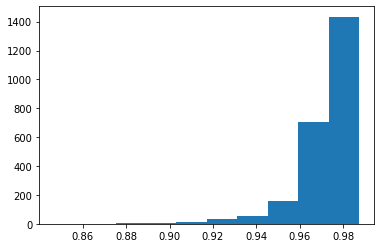

In [6]:
plt.hist(list(softdice.values()));

In [7]:
for k,v in softdice.items():
    if v<0.96:
        softdice[k] = np.array([0,1])
    else:
        softdice[k] = np.array([1,0])


In [8]:
image_dir = Path('/media/arjun/VascLab EVO/projects/oct_ca_seg/actual final data/images')
s_size = (256, 256)
c_size = s_size

In [9]:
oct_class_dataset = OCTClassificationDataset(image_data_dir=image_dir, labels_dict=softdice, start_size=s_size,cropped_size=c_size, transform=True)

Make sure everything checks out

In [25]:
oct_class_dataset[0]['input'].size(), oct_class_dataset[0]['label'], len(oct_class_dataset)

(torch.Size([1, 256, 256]), tensor([1, 0]), 2403)

Can put any number less than len(oct_class_dataset) in here to show image, label and colorbar!

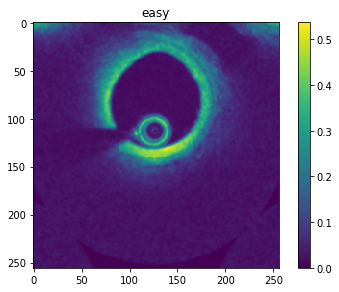

In [23]:
oct_class_dataset.visualise3(900)

now import the appropriate model opts. this needs to be transcribed from the appropriate opts.txt for now. script this for later

In [21]:
model_opts = {'start_size': (256, 256),
              'uptype': 'deconv',
              'c_size': (256, 256),
              'inputchannels': 3,
              'primdims': 16,
              'primmaps': 4,
              'maps1': 8,
              'maps2': 16,
              'maps3': 24,
              'dims1': 24,
              'dims2': 32,
              'dims3': 48}

In [12]:
class ClassifyCapsNet(torch.nn.Module):
    '''Classification net that uses downsampling pathway of Capsnet for transfer learning!'''
    def __init__(self, opt):
        super(ClassifyCapsNet, self).__init__()
        self.opt = opt
        